<a href="https://colab.research.google.com/github/indrajitrdas/Product_Classification/blob/master/Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# **Installing required libraries**

In [0]:
#!pip install -q keras
!pip install -U -q PyDrive
!pip install split-folders
!pip install h5py

# **Importing required libraries**

In [0]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import os
import PIL
import split_folders
from IPython.display import Image
from keras.applications import VGG16
from keras.applications import Xception
from keras.models import Sequential
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten

# **Custom Functions** 
The following functions were defined
1. `show_image`
2. `show_img`
3. `color_histogram`
4. `grayscale_histogram`
5. `image_equalize`
6. `image_equalize_CHLAE`
7. `convert_BGR2GRAY`
8. `resize_image`
9. `resize_BGR2GRAY`

Even though some of the functionalities are automatically done by Keras, I tend to use these for EDA and basic data processing. 

In [0]:
# Function to Display Images by FilePath
def show_image(filepath):
  img = cv2.imread(filepath)
  plt.imshow(img)
  plt.show()
  
def show_img(filepath):
  figsize=(18, 16)
  image = Image(filepath)
  return image
  
# Color Histogram
def color_histogram(filepath):
  img = cv2.imread(filepath)
  color = ('b','g','r')
  for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  plt.show()
   
# Grayscale Histogram
def grayscale_histogram(filepath):
  img = cv2.imread(filepath, 0)
  hist = cv2.calcHist(img, [0],None,[256],[0,256])
  plt.plot(hist)
  plt.xlim([0,256])
  plt.show()
  
# Basic Equalize
def image_equalize(dir):
  for root, dirs, files in os.walk(dir):
    for name in files:
      fname = os.path.join(root, name)
      print(fname)
      grayscale_img = cv2.imread(fname, 0)
      grayscale_equalized_img = cv2.equalizeHist(grayscale_img)
      cv2.imwrite(fname,grayscale_equalized_img)

# CHLAE equalize
def image_equalize_CHLAE(dir):
  for root, dirs, files in os.walk(dir):
    for name in files:
      fname = os.path.join(root, name)
      print(fname)
      grayscale_img = cv2.imread(fname, 0)
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      grayscale_equalized_img_CHLAE = clahe.apply(grayscale_img)
      cv2.imwrite(fname, grayscale_equalized_img_CHLAE)
      
# Convert images in directory and sub directories from color to Grayscale 
def convert_BGR2GRAY(path):
  for root, dirs, files in os.walk(path):
    for name in files:
      fname = os.path.join(root, name)
      #print(fname)
      img = cv2.imread(fname)
      grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(fname,grayscale_img)
      
# Resize images in directory and sub directories to new img_height and img_width       
def resize_image(path, img_height, img_width):
  for root, dirs, files in os.walk(path):
    for name in files:
      fname = os.path.join(root, name)
      img = cv2.imread(fname)
      resized_img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
      cv2.imwrite(fname,resized_img)
      
# Resize and convert to grayscale all images in directory and sub directories
def resize_BGR2GRAY(path, img_height, img_width):
  for root, dirs, files in os.walk(path):
    for name in files:
      fname = os.path.join(root, name)
      img = cv2.imread(fname)
      resized_img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
      grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(fname,grayscale_img)

# **Removing Bad Images**
Identified and removed:
1. Images that say 'IMAGE UNAVAILABLE'
2. Images that cannot be opened


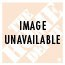

In [265]:
show_img('/content/gdrive/My Drive/Datasets/HomeDepot/Test_3/1.jpg')

In [0]:
for root, dirs, files in os.walk("/content/gdrive/My Drive/Datasets/HomeDepot/home_depot_images_original"):
  for name in files:
    fname = os.path.join(root, name)
    try:
      img = cv2.imread(fname)
      if img.shape != (1000,1000,3):
        os.remove(fname)
    except:
      os.remove(fname)

# **EDA**
**1. Count Classes and Samples**

The dataset suffers from** class imbalance**. For example: bookcase and chandelier have 417 and 546 images as opposed to night_stands that have only 30 images. There are three possible solutions to overcome this problem.

1. Undersample the majority class : This problem with this approach is that we loose data that is available.
2. Create augmented images from samples of minority classes.
3. Gather more samples for the minority classes.
4. Use F1 Score and AUC-ROC curve.


In [5]:
path = "/content/gdrive/My Drive/Datasets/HomeDepot/home_depot_images_original"
folders = ([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]) 
for folder in folders:
  contents = os.listdir(os.path.join(path,folder))
  print(folder,len(contents))

bar_stool 272
bookcase 417
chandelier 546
dining_chair 382
market_umbrella 209
night_stands 30
ottoman 164
sconces 383
table_lamp 240
vases 192


**2.Grayscale Histogram of images**

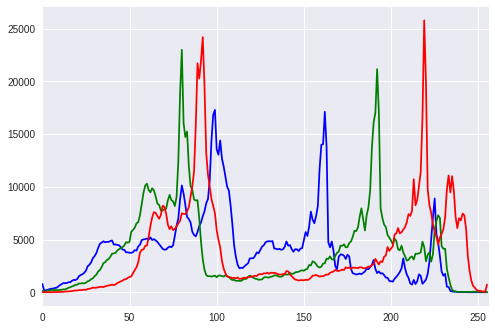

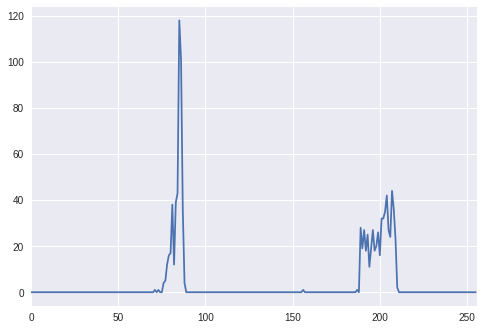

In [114]:
image_dir1 = "/content/gdrive/My Drive/Datasets/HomeDepot/Test/15.jpg"
image_dir2 = "/content/gdrive/My Drive/Datasets/HomeDepot/Test/13.jpg"
color_histogram(image_dir1)
grayscale_histogram(image_dir1)

# **Model for separating Product Images and Lifestyle Images**

In order to design a classifier to separate Product Images and Lifestyle Images, I handpicked some images to create a separate dataset. This would be a binary classifier where VGG16 is used to extract features with added FC layers with a Sigmoid as an output.

**FUTURE WORK : **

The solutions obtained is more complicated than required and I would like to try the following two techniques in the near future.
1. Design a classifier where each image is represented by a grayscale histogram of length 256. This would greatly reduce the input dimension and would require a much small network to train. 
2. Using bottle neck features extracted from some pretrained network and using Logistic Regression or SVM. 

**Splitting into Train/Validation/Testing **

In [0]:
split_folders.ratio('/content/gdrive/My Drive/Datasets/HomeDepot/ProductVsLifeStyle', output="/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_ProductVsLifeStyle", seed=1337, ratio=(.8, .1, .1))

In [266]:
np.random.seed(1333)
vgg_conv_binary = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv_binary.layers[:-4]:
    layer.trainable = False
for layer in vgg_conv_binary.layers:
    print(layer, layer.trainable)
    
model_binary = models.Sequential()
model_binary.add(vgg_conv_binary)
 
# New layers
model_binary.add(layers.Flatten())
model_binary.add(layers.Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_binary.add(layers.Dropout(0.5))
model_binary.add(layers.Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_binary.add(layers.Dropout(0.5))
model_binary.add(layers.Dense(1, activation='sigmoid'))

<keras.engine.input_layer.InputLayer object at 0x7f34c8b11e48> False
<keras.layers.convolutional.Conv2D object at 0x7f34c8b11da0> False
<keras.layers.convolutional.Conv2D object at 0x7f34c8b11cc0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34c89d1cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f34c89e0780> False
<keras.layers.convolutional.Conv2D object at 0x7f34c898f160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34c89a47b8> False
<keras.layers.convolutional.Conv2D object at 0x7f34c89a42e8> False
<keras.layers.convolutional.Conv2D object at 0x7f34c8952438> False
<keras.layers.convolutional.Conv2D object at 0x7f34c8968a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34c8981d30> False
<keras.layers.convolutional.Conv2D object at 0x7f34c8981eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f34c892cd30> False
<keras.layers.convolutional.Conv2D object at 0x7f34c88d8550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34c88f1c88>

**Model Description **

In [267]:
# Model Summary
model_binary.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_80 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_56 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_57 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 1025      
Total para

In [268]:
train_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_ProductVsLifeStyle/train'
validation_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_ProductVsLifeStyle/val'
test_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_ProductVsLifeStyle/test'

train_datagen_binary = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen_binary = ImageDataGenerator(rescale=1./255)

test_datagen_binary = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 16
val_batchsize = 16

train_generator_binary = train_datagen_binary.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='binary')
 
validation_generator_binary = validation_datagen_binary.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='binary',
        shuffle=False)

test_generator_binary = test_datagen_binary.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',  
        shuffle=False)

Found 446 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [269]:
# Compile the model
model_binary.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model_binary.fit_generator(
      train_generator_binary,
      steps_per_epoch=train_generator_binary.samples/train_generator_binary.batch_size ,
      epochs=30,
      validation_data=validation_generator_binary,
      validation_steps=validation_generator_binary.samples/validation_generator_binary.batch_size,
      verbose=1)
 
# Save the model
model_binary.save('model_binary.h5')

Epoch 1/30
28/27 [==============================] - 20s 703ms/step - loss: 24.6569 - acc: 0.8055 - val_loss: 20.2682 - val_acc: 0.9636
Epoch 2/30
28/27 [==============================] - 15s 522ms/step - loss: 17.5648 - acc: 0.9420 - val_loss: 14.8302 - val_acc: 0.9455
Epoch 3/30
28/27 [==============================] - 15s 536ms/step - loss: 12.7766 - acc: 0.9732 - val_loss: 10.7825 - val_acc: 0.9636
Epoch 4/30
28/27 [==============================] - 15s 538ms/step - loss: 9.4953 - acc: 0.9620 - val_loss: 8.1228 - val_acc: 0.9636
Epoch 5/30
28/27 [==============================] - 15s 538ms/step - loss: 7.2144 - acc: 0.9955 - val_loss: 6.4281 - val_acc: 0.9636
Epoch 6/30
28/27 [==============================] - 15s 538ms/step - loss: 5.8794 - acc: 0.9732 - val_loss: 5.2599 - val_acc: 0.9636
Epoch 7/30
28/27 [==============================] - 15s 539ms/step - loss: 4.7641 - acc: 0.9955 - val_loss: 4.4715 - val_acc: 0.9455
Epoch 8/30
28/27 [==============================] - 15s 537ms/s

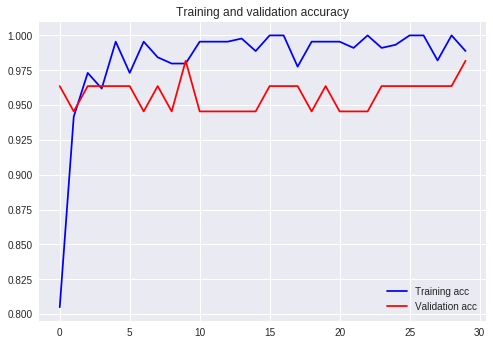

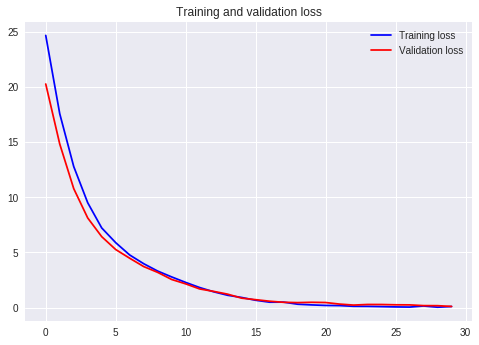

In [270]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Evaluation of Binary Classifier on Test Set**

Since both the classes are balanced, I am using accuracy as an evaluation metric. 

In [0]:
#Evaluate model on test set
test_generator_binary.reset()
scores = model_binary.evaluate_generator(test_generator_binary, steps = 10)

In [272]:
print(model_binary.metrics_names)
print(scores)

['loss', 'acc']
[1.0654250971198855, 0.9025974025974026]


# **Transfer Learning using VGG16**

The decision of using **VGG16** was made based on the fact that I have on previous occasions used **Xception** and **ResNet50** for other projects. I am aware of the fact that VGG16 **does not provide the highest accuracy** on Imagenet and I could have gotten a better accuracy if I had used other networks.

It was mentioned in the question that product images are good for training. Since I am using VGG16 which is pretrained on Imagenet, I felt that there was a good chance that the classifier can perform reasonably well on lifestyle images because some of the classes that are present in Imagenet are mostly lifestyle images. 

**Future Work**

Since I did not remove lifestyle images from the dataset using the binary classifier designed above, I would later try and see the effect of only product images for training and compare performance of both methods.

In [0]:
np.random.seed(1337)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [184]:
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f34ca0f69e8> False
<keras.layers.convolutional.Conv2D object at 0x7f34ca0f6c88> False
<keras.layers.convolutional.Conv2D object at 0x7f34ca0f62b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34cba420b8> False
<keras.layers.convolutional.Conv2D object at 0x7f34cba426a0> False
<keras.layers.convolutional.Conv2D object at 0x7f34cba7b1d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34cba0d828> False
<keras.layers.convolutional.Conv2D object at 0x7f34cba0d390> False
<keras.layers.convolutional.Conv2D object at 0x7f34cba3a470> False
<keras.layers.convolutional.Conv2D object at 0x7f34cb9cdac8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34cb9e8d68> False
<keras.layers.convolutional.Conv2D object at 0x7f34cb9e8ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f34cb997390> False
<keras.layers.convolutional.Conv2D object at 0x7f34cb9b1dd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f34cb95c668>

In [185]:
# Create the model
model = models.Sequential()
model.add(vgg_conv)
 
# New Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
 
# Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                10250     
Total para

In [188]:
train_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_RGB_1000x1000/train'
validation_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_RGB_1000x1000/val'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 16
val_batchsize = 16

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 2252 images belonging to 10 classes.
Found 283 images belonging to 10 classes.


In [189]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('Product_classifier.h5')

Epoch 1/30
141/140 [==============================] - 654s 5s/step - loss: 18.2473 - acc: 0.4362 - val_loss: 11.2637 - val_acc: 0.6784
Epoch 2/30
141/140 [==============================] - 71s 504ms/step - loss: 9.4979 - acc: 0.6698 - val_loss: 7.8076 - val_acc: 0.7703
Epoch 3/30
141/140 [==============================] - 75s 530ms/step - loss: 6.9049 - acc: 0.7506 - val_loss: 5.8267 - val_acc: 0.8198
Epoch 4/30
141/140 [==============================] - 75s 532ms/step - loss: 5.1969 - acc: 0.7906 - val_loss: 4.6442 - val_acc: 0.8269
Epoch 5/30
141/140 [==============================] - 75s 530ms/step - loss: 4.0854 - acc: 0.8224 - val_loss: 3.8687 - val_acc: 0.7809
Epoch 6/30
141/140 [==============================] - 75s 532ms/step - loss: 3.1591 - acc: 0.8454 - val_loss: 3.0026 - val_acc: 0.8410
Epoch 7/30
141/140 [==============================] - 75s 531ms/step - loss: 2.5248 - acc: 0.8552 - val_loss: 2.5579 - val_acc: 0.8198
Epoch 8/30
141/140 [==============================] - 7

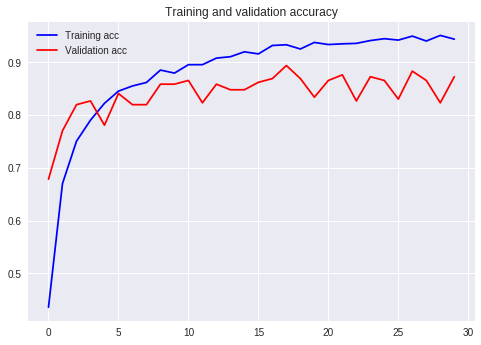

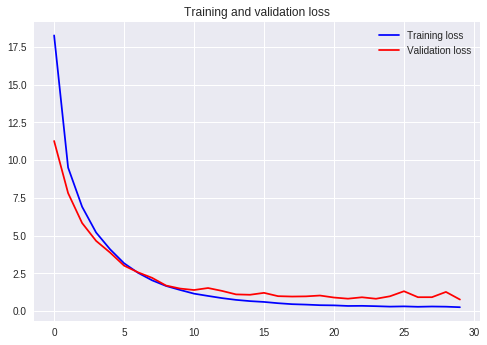

In [190]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Evaluation of Product Classifier on Test Set**

Since classes are not balanced, accuracy should not be the preferred way of measuring performance.  

In [198]:
test_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_RGB_1000x1000/test'
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',  
        shuffle=False)

Found 298 images belonging to 10 classes.


In [0]:
#Evaluate model on test set
test_generator.reset()
scores_model = model.evaluate_generator(test_generator, steps = 10)

In [204]:
print(model.metrics_names)
print(scores_model)

['loss', 'acc']
[0.4151238888502121, 0.91875]


In [232]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 298 // 16)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 0 27  0  1  0  1  0  0  1  0]
 [ 0  9 30  2  0  0  0  0  0  1]
 [ 2  0 19 30  0  0  1  1  1  0]
 [ 0  0  0  9 15  2 11  2  0  1]
 [ 0  1  3  0  0  1  4  9  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  2  0  0  0  0 14  0  0]
 [ 2  1  1  0  0  0  0  6 19  9]
 [11  0  0  2  0  0  0  0  1  9]
 [13  5  0  1  0  0  0  0  0  0]]


In [215]:
print('Classification Report')
target_names = ['bar_stool', 'bookcase', 'chandelier','dining_chair','market_umbrella','night_stands','ottoman', 'scones','table_lamp', 'vases']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
                 precision    recall  f1-score   support

      bar_stool       0.39      0.37      0.38        30
       bookcase       0.56      0.57      0.56        42
     chandelier       0.64      0.65      0.64        54
   dining_chair       0.56      0.62      0.59        40
market_umbrella       0.13      0.11      0.12        18
   night_stands       0.00      0.00      0.00         3
        ottoman       0.00      0.00      0.00        16
         scones       0.57      0.53      0.55        38
     table_lamp       0.32      0.30      0.31        23
          vases       0.20      0.21      0.21        19

      micro avg       0.45      0.45      0.45       283
      macro avg       0.34      0.34      0.34       283
   weighted avg       0.45      0.45      0.45       283



# **Self-designed CNN**

**Converting Images to GrayScale and resizing them to 128x128**

In [0]:
path = "/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_GrayScale_128x128"
img_height = 128
img_width = 128      
resize_BGR2GRAY(path, img_height, img_width)

**Image Equalization** 

Image Equalization introduced noise in the data. I tried using more advanced equalization techniques but the results were the same. It would be interesting to see if noise removal techhniques have any effect.

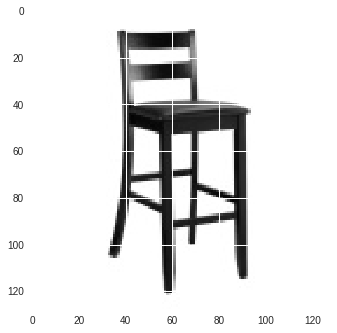

In [257]:
show_image('/content/gdrive/My Drive/Datasets/HomeDepot/Test_2/1.jpg')

In [258]:
image_equalize('/content/gdrive/My Drive/Datasets/HomeDepot/Test_2')

/content/gdrive/My Drive/Datasets/HomeDepot/Test_2/1.jpg


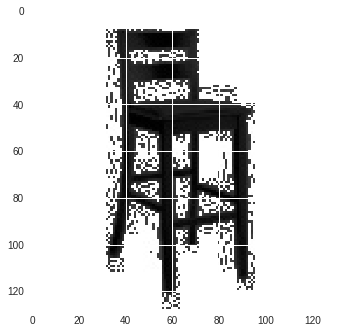

In [259]:
show_image('/content/gdrive/My Drive/Datasets/HomeDepot/Test_2/1.jpg')

In [247]:
# Hyper-Parameters
batchsize = 16
num_classes = 10
epochs = 30

# Input Shape
img_width = 128
img_height = 128

# Data Directory
train_data_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_GrayScale_128x128/train'
validation_data_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_GrayScale_128x128/val'
test_data_dir = '/content/gdrive/My Drive/Datasets/HomeDepot/Dataset_Cleaned_GrayScale_128x128/test'

# Input Dimension Ordering
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Create Model
def createModel():
    model = Sequential()
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', input_shape = input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
 
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
 
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
     
    return model
  
model_CNN = createModel() 
model_CNN.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 32768)             0         
__________

In [235]:
train_datagen_smallCNN = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen_smallCNN = ImageDataGenerator(rescale=1./255)
test_datagen_smallCNN = ImageDataGenerator(rescale=1./255) 

train_generator_smallCNN = train_datagen_smallCNN.flow_from_directory(
        train_data_dir,
        target_size=(128, 128),
        batch_size=batchsize,
        class_mode='categorical')
 
validation_generator_smallCNN = validation_datagen_smallCNN.flow_from_directory(
        validation_data_dir,
        target_size=(128, 128),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)


test_generator_smallCNN = test_datagen_smallCNN.flow_from_directory(
        test_data_dir,
        target_size=(128, 128),
        batch_size=batchsize,
        class_mode='categorical',  
        shuffle=False)

Found 2252 images belonging to 10 classes.
Found 283 images belonging to 10 classes.
Found 298 images belonging to 10 classes.


In [248]:
# Train the model
history = model_CNN.fit_generator(
      train_generator_smallCNN,
      steps_per_epoch=train_generator_smallCNN.samples/train_generator_smallCNN.batch_size,
      epochs=epochs,
      validation_data=validation_generator_smallCNN,
      validation_steps=validation_generator_smallCNN.samples/validation_generator_smallCNN.batch_size,
      verbose=1)
 
# Save the model
model_CNN.save('Small_CNN.h5')

Epoch 1/30
141/140 [==============================] - 24s 172ms/step - loss: 4.5880 - acc: 0.1772 - val_loss: 2.3529 - val_acc: 0.1661
Epoch 2/30
141/140 [==============================] - 20s 139ms/step - loss: 2.3524 - acc: 0.2100 - val_loss: 2.2459 - val_acc: 0.2544
Epoch 3/30
141/140 [==============================] - 20s 143ms/step - loss: 2.2800 - acc: 0.2308 - val_loss: 2.2217 - val_acc: 0.2403
Epoch 4/30
141/140 [==============================] - 20s 143ms/step - loss: 2.2615 - acc: 0.2317 - val_loss: 2.1986 - val_acc: 0.2580
Epoch 5/30
141/140 [==============================] - 20s 143ms/step - loss: 2.2709 - acc: 0.2339 - val_loss: 2.2618 - val_acc: 0.2120
Epoch 6/30
141/140 [==============================] - 20s 143ms/step - loss: 2.2511 - acc: 0.2395 - val_loss: 2.1648 - val_acc: 0.2580
Epoch 7/30
141/140 [==============================] - 20s 144ms/step - loss: 2.2489 - acc: 0.2453 - val_loss: 2.1632 - val_acc: 0.2580
Epoch 8/30
141/140 [==============================] - 2

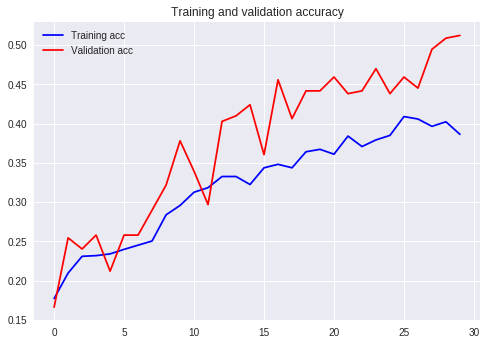

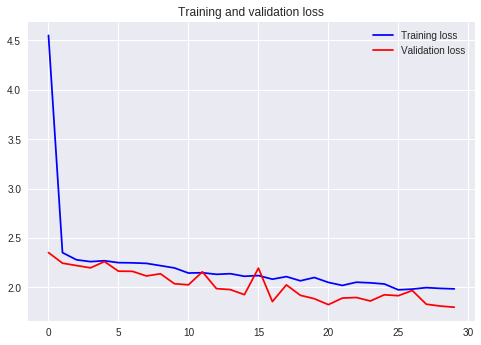

In [249]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Analysis**

Just by looking at the graphs we can see that transfer learning with VGG16 performed better than the smaller CNN.  

# Personal Note

I would like to thank Home Depot and the Data Science Team for giving me the opportunity to work on this problem. I enjoyed woking on the project very much. I tried out some new algorithms and techniques that were very interesting. I have submitted the results I was able to obtain in the given timeframe. A big limitation for the project was lack of support of my personal laptop for these heavy frameworks and the non-responsive nature of Google Colab. I will continue to fine tune my approach and think of new techniques that I can utilize to make it better. 